## Refine Mesenchymal cell annotations - relabelling uncertain cells based on majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=True,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

In [6]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Mesenchyme_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 18903 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [8]:
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Mes_20230226.csv.gz',compression='gzip',index_col=0)

In [9]:
adata_scanvi

LV1       LV2       LV3       LV4  \
index                                                                      
AAAGCAACACCATCCT-4918STDY7273964 -0.057625 -0.042171 -0.285732 -0.001239   
AAATGCCAGACCTAGG-4918STDY7273964  0.059836 -0.099243  1.511871 -0.068022   
AAATGCCGTCTAGAGG-4918STDY7273964  0.019607 -0.035252 -0.405572  0.124444   
AACCATGGTGGTCTCG-4918STDY7273964  0.008183 -0.024308  0.072217 -0.009606   
AACCGCGGTGATAAGT-4918STDY7273964 -0.028659  0.043448 -1.189826  0.087071   
...                                    ...       ...       ...       ...   
TTTCCTCGTTACCAGT-GSM4546346      -0.040045  0.001779 -1.773015 -0.104590   
TTTGCGCCACAACGCC-GSM4546346       0.127734  0.044807  0.661179 -0.003204   
TTTGCGCGTCTCATCC-GSM4546346       0.011015  0.034218 -1.095899 -0.081064   
TTTGGTTGTCAGCTAT-GSM4546346       0.051867  0.034067 -1.260726 -0.077338   
TTTGTCAGTGGTGTAG-GSM4546346       0.004005 -0.002745 -0.776863 -0.105804   

                                       LV5       LV6       LV7       LV8  \
index                                                                      
AAAGCAACACCATCCT-4918STDY7273964 -0.019258  0.336607 -0.339518  0.408953   
AAATGCCAGACCTAGG-4918STDY7273964  0.118960 -1.031133 -0.278688  0.207325   
AAATGCCGTCTAGAGG-4918STDY7273964  0.110700 -0.479515  1.004145 -0.879032   
AACCATGGTGGTCTCG-4918STDY7273964  0.085716 -0.429228 -0.302057 -0.427956   
AACCGCGGTGATAAGT-4918STDY7273964 -0.060540  0.809780  0.395918 -1.361331   
...                                    ...       ...       ...       ...   
TTTCCTCGTTACCAGT-GSM4546346      -0.120331 -0.124013  1.264487  0.927511   
TTTGCGCCACAACGCC-GSM4546346       0.068617  0.153232 -0.654127 -0.294501   
TTTGCGCGTCTCATCC-GSM4546346      -0.038080  0.292692 -0.475019 -0.650030   
TTTGGTTGTCAGCTAT-GSM4546346       0.071254  0.913474  0.048101  0.525964   
TTTGTCAGTGGTGTAG-GSM4546346      -0.003548  0.399736 -0.541191 -0.450869   

                                       LV9      LV10      LV11      LV12  \
index                                                                      
AAAGCAACACCATCCT-4918STDY7273964  0.071482 -0.243724 -0.177286 -0.468702   
AAATGCCAGACCTAGG-4918STDY7273964 -4.254483  0.013175 -0.745814  0.882726   
AAATGCCGTCTAGAGG-4918STDY7273964  1.795589  1.557218 -0.408852  0.420887   
AACCATGGTGGTCTCG-4918STDY7273964 -2.482032  0.327178 -0.643279 -1.052222   
AACCGCGGTGATAAGT-4918STDY7273964  0.599943  0.239911  0.636280 -0.759169   
...                                    ...       ...       ...       ...   
TTTCCTCGTTACCAGT-GSM4546346      -0.361215 -0.976406  1.606136  1.453451   
TTTGCGCCACAACGCC-GSM4546346      -1.518063  0.609824  1.401071  0.116217   
TTTGCGCGTCTCATCC-GSM4546346      -0.994066  0.164745  0.913382  1.198472   
TTTGGTTGTCAGCTAT-GSM4546346      -0.083570  0.520378 -0.137914 -0.375696   
TTTGTCAGTGGTGTAG-GSM4546346      -1.511899  0.511284  0.654503  1.422698   

                                      LV13      LV14      LV15      LV16  \
index                                                                      
AAAGCAACACCATCCT-4918STDY7273964  0.509646  0.002497 -0.112188  0.003067   
AAATGCCAGACCTAGG-4918STDY7273964 -0.138928 -0.108574 -0.003928 -0.067769   
AAATGCCGTCTAGAGG-4918STDY7273964 -0.921947  0.123123  0.102065 -0.091211   
AACCATGGTGGTCTCG-4918STDY7273964  0.314086 -0.072258 -0.014911 -0.008163   
AACCGCGGTGATAAGT-4918STDY7273964  0.130200  0.013647  0.074249  0.008936   
...                                    ...       ...       ...       ...   
TTTCCTCGTTACCAGT-GSM4546346       0.026392  0.005958 -0.033165  0.077868   
TTTGCGCCACAACGCC-GSM4546346      -1.616143  0.037230 -0.046146  0.005901   
TTTGCGCGTCTCATCC-GSM4546346       0.742885 -0.027088 -0.028627  0.090453   
TTTGGTTGTCAGCTAT-GSM4546346      -0.074272  0.051483 -0.067260  0.039172   
TTTGTCAGTGGTGTAG-GSM4546346       0.742269 -0.062682  0.013219  0.046901   

                                      LV17      LV18      LV19      LV20  
index   

In [10]:
adata.obsm['X_scANVI'] = adata_scanvi

In [11]:
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Mes_20230226.csv',index_col=0)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (84,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
adata_meta

latent_cell_probability  \
index                                                       
AAAGCAACACCATCCT-4918STDY7273964                 0.999041   
AAATGCCAGACCTAGG-4918STDY7273964                 0.999939   
AAATGCCGTCTAGAGG-4918STDY7273964                 0.999971   
AACCATGGTGGTCTCG-4918STDY7273964                 0.999627   
AACCGCGGTGATAAGT-4918STDY7273964                 0.999938   
...                                                   ...   
TTTCCTCGTTACCAGT-GSM4546346                      0.999864   
TTTGCGCCACAACGCC-GSM4546346                      0.999514   
TTTGCGCGTCTCATCC-GSM4546346                      0.999834   
TTTGGTTGTCAGCTAT-GSM4546346                      0.999583   
TTTGTCAGTGGTGTAG-GSM4546346                      0.999744   

                                  latent_RT_efficiency cecilia22_predH  \
index                                                                    
AAAGCAACACCATCCT-4918STDY7273964              0.731684     Fibroblasts   
AAATGCCAGACCTAGG-4918STDY7273964              2.868829         T cells   
AAATGCCGTCTAGAGG-4918STDY7273964              3.864576     Fibroblasts   
AACCATGGTGGTCTCG-4918STDY7273964              1.257938         T cells   
AACCGCGGTGATAAGT-4918STDY7273964              2.723624     Fibroblasts   
...                                                ...             ...   
TTTCCTCGTTACCAGT-GSM4546346                   1.901295             ILC   
TTTGCGCCACAACGCC-GSM4546346                   1.127976             ILC   
TTTGCGCGTCTCATCC-GSM4546346                   1.352647         T cells   
TTTGGTTGTCAGCTAT-GSM4546346                   1.129782     Fibroblasts   
TTTGTCAGTGGTGTAG-GSM4546346                   1.542765         T cells   

                                  cecilia22_predH_prob  \
index                                                    
AAAGCAACACCATCCT-4918STDY7273964              0.118177   
AAATGCCAGACCTAGG-4918STDY7273964              0.918127   
AAATGCCGTCTAGAGG-4918STDY7273964              0.986204   
AACCATGGTGGTCTCG-4918STDY7273964              0.073594   
AACCGCGGTGATAAGT-4918STDY7273964              0.999965   
...                                                ...   
TTTCCTCGTTACCAGT-GSM4546346                   0.000069   
TTTGCGCCACAACGCC-GSM4546346                   0.004255   
TTTGCGCGTCTCATCC-GSM4546346                   0.091294   
TTTGGTTGTCAGCTAT-GSM4546346                   0.993050   
TTTGTCAGTGGTGTAG-GSM4546346                   0.000322   

                                 cecilia22_predH_uncertain    cecilia22_predL  \
index                                                                           
AAAGCAACACCATCCT-4918STDY7273964                 Uncertain        Fibroblasts   
AAATGCCAGACCTAGG-4918STDY7273964                   T cells  Endothelial cells   
AAATGCCGTCTAGAGG-4918STDY7273964               Fibroblasts        Fibroblasts   
AACCATGGTGGTCTCG-4918STDY7273964                 Uncertain  Endothelial cells   
AACCGCGGTGATAAGT-4918STDY7273964               Fibroblasts        Fibroblasts   
...                                                    ...                ...   
TTTCCTCGTTACCAGT-GSM4546346                      Uncertain           NK cells   
TTTGCGCCACAACGCC-GSM4546346                      Uncertain        Fibroblasts   
TTTGCGCGTCTCATCC-GSM4546346                      Uncertain           NK cells   
TTTGGTTGTCAGCTAT-GSM4546346                    Fibroblasts        Fibroblasts   
TTTGTCAGTGGTGTAG-GSM4546346                      Uncertain           NK cells   

                                  cecilia22_predL_prob  \
index                                                    
AAAGCAACACCATCCT-4918STDY7273964              0.304166   
AAATGCCAGACCTAGG-4918STDY7273964              0.712799   
AAATGCCGTCTAGAGG-4918STDY7273964              0.929843   
AACCATGGTGGTCTCG-4918STDY7273964              0.054005   
AACCGCGGTGATAAGT-4918STDY7273964              0.999881   
...                                                ...   
TTTC

In [13]:
adata.obs = adata_meta

In [14]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


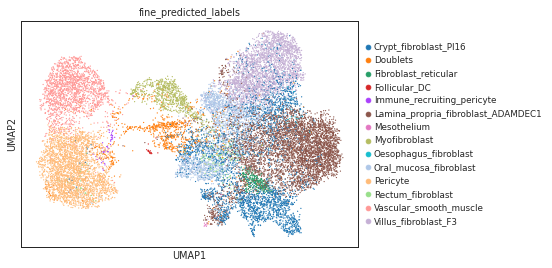

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

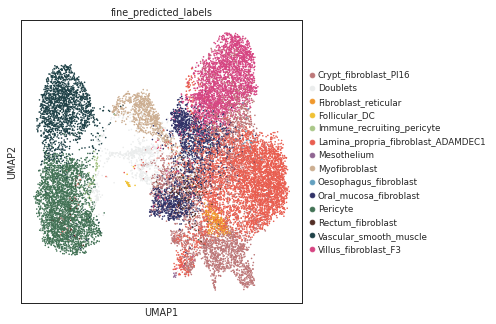

In [16]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = ['#bd7879',#'Crypt_fibroblast_PI16', 
                                                          '#ebeded',#doublets
           '#f0982c',#'Follicular_DC', 
                                                          '#f0c134',#'Stromal_fibroblast_reticular',
           '#AAC789',#'Immune_recruiting_pericyte',
           '#e95e50',#'Lamina_propria_fibroblast_ADAMDEC1', 
           '#8F6592',#'Mesothelium', 
           '#CCAE91',#'Myofibroblast',
           '#63A0C0',#'Oesophagus_fibroblast', 
           '#303267',#'Oral_mucosa_fibroblast', 
           '#437356',#'Pericyte',
           '#522e25',#'Rectum_fibroblast',
           
           '#1E4147',#'Vascular_smooth_muscle',
           '#d64582'#'Villus_fibroblast_F3'
                                                         ]
           ,size=10,save='Mes_scanviannot_predicted.pdf')

In [17]:
adata.X.max()

12104.0

In [18]:
adata.layers['counts'] = adata.X

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
marker_genes_dict = {'General fibroblast markers':['VCAN', 'PDGFRA'],
                     'General smooth muscle/pericyte markers':['TAGLN', 'ACTA2','TPM2', 'MYH11'],
                     'Crypt_fibroblast_PI16':['PI16','RSPO3','SFRP1','ITM2A'],
                     'Follicular_DC':['FDCSP','SRGN','CR2','CLU','CSTA'],
                     'Immune_recruiting_pericyte':['GPC3','COL14A1','ECRG4','ID4','FHL2','CXCL12'],
                     'Lamina_propria_fibroblast_ADAMDEC1':['ADAMDEC1','CXCL14','ADAM28','CCL11','CCL8','CCL13','CFD'],
                     'Mesothelium':['UPK3B','MSLN','SLPI','KRT19'],
                     'Myofibroblast':['ACTG2','HHIP','SOSTDC1','NPNT'],
                     'Oesophagus_fibroblast':['APOD','PLPP1','MFAP4','IFITM1','RASD1'],
                     'Oral_mucosa_fibroblast':['CTHRC1','COL12A1','COL1A1','CTSK','COL5A2'],
                     'Pericyte':['CD36','COX4I2','HIGD1B','RGS5','NDUFA4L2'],
                     'Rectum_fibroblast':['KCNN3','THBS4','FNDC1','PPFIBP1'],
                     'Stromal_fibroblast_retictular':['CCL21','CCL19','TNFSF13B','TDO2'],
                     'Vascular_smooth_muscle':['RERGL','MUSTN1','LBH','NET1','MAP3K20'],
                     'Villus_fibroblast_F3':['F3','PLAT','HSD17B2','SOX6']}

In [21]:
adata

AnnData object with n_obs × n_vars = 18903 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


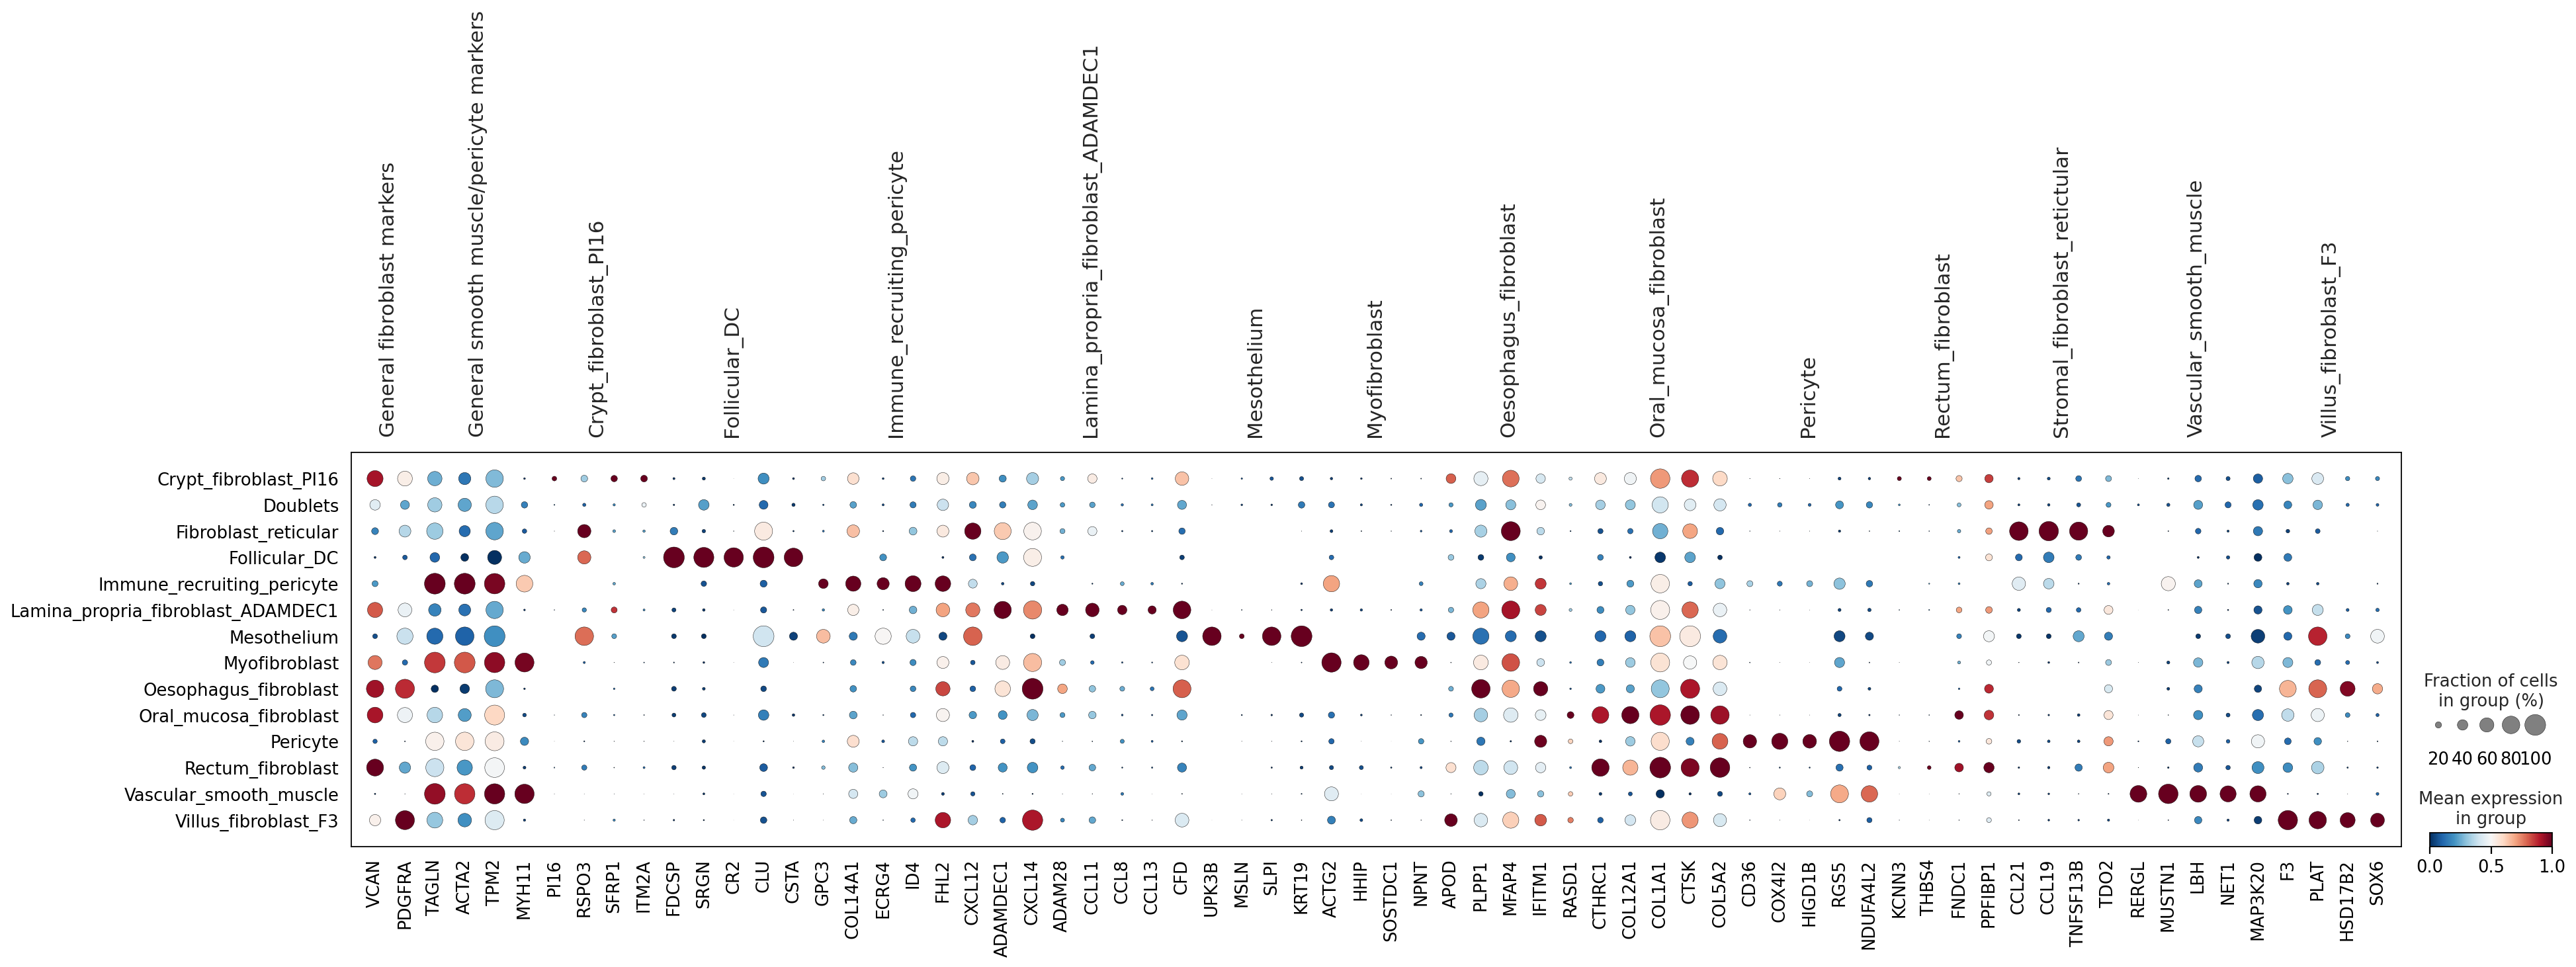

In [22]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var')

In [23]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [24]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.5000855147838592


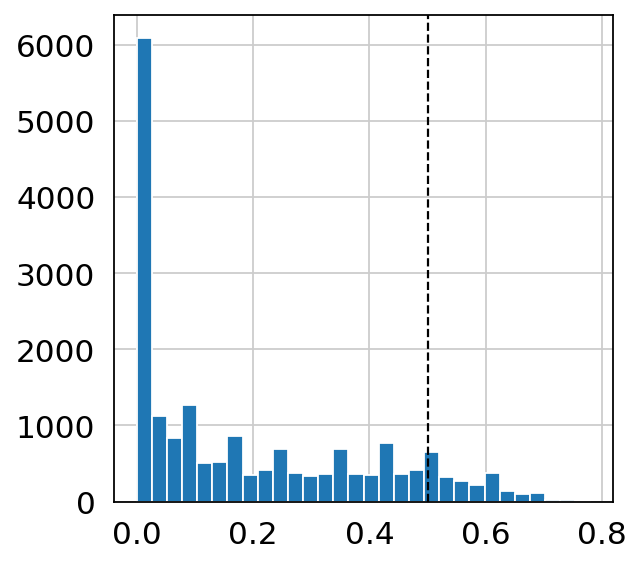

In [25]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.axvline(x=p, color='black', linestyle='dashed', linewidth=1)
plt.savefig('Mes_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [26]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-26-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [27]:
adata.obs['fine_predicted_labels'].unique()

['Lamina_propria_fibroblast_ADAMDEC1', 'Vascular_smooth_muscle', 'Oral_mucosa_fibroblast', 'Fibroblast_reticular', 'Pericyte', ..., 'Follicular_DC', 'Rectum_fibroblast', 'Oesophagus_fibroblast', 'Immune_recruiting_pericyte', 'Mesothelium']
Length: 14
Categories (14, object): ['Crypt_fibroblast_PI16', 'Doublets', 'Fibroblast_reticular', 'Follicular_DC', ..., 'Pericyte', 'Rectum_fibroblast', 'Vascular_smooth_muscle', 'Villus_fibroblast_F3']

In [28]:
#mark cells are unknown based on cut off of 90th percentile rounded to the nearest second decimal
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.50, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [29]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

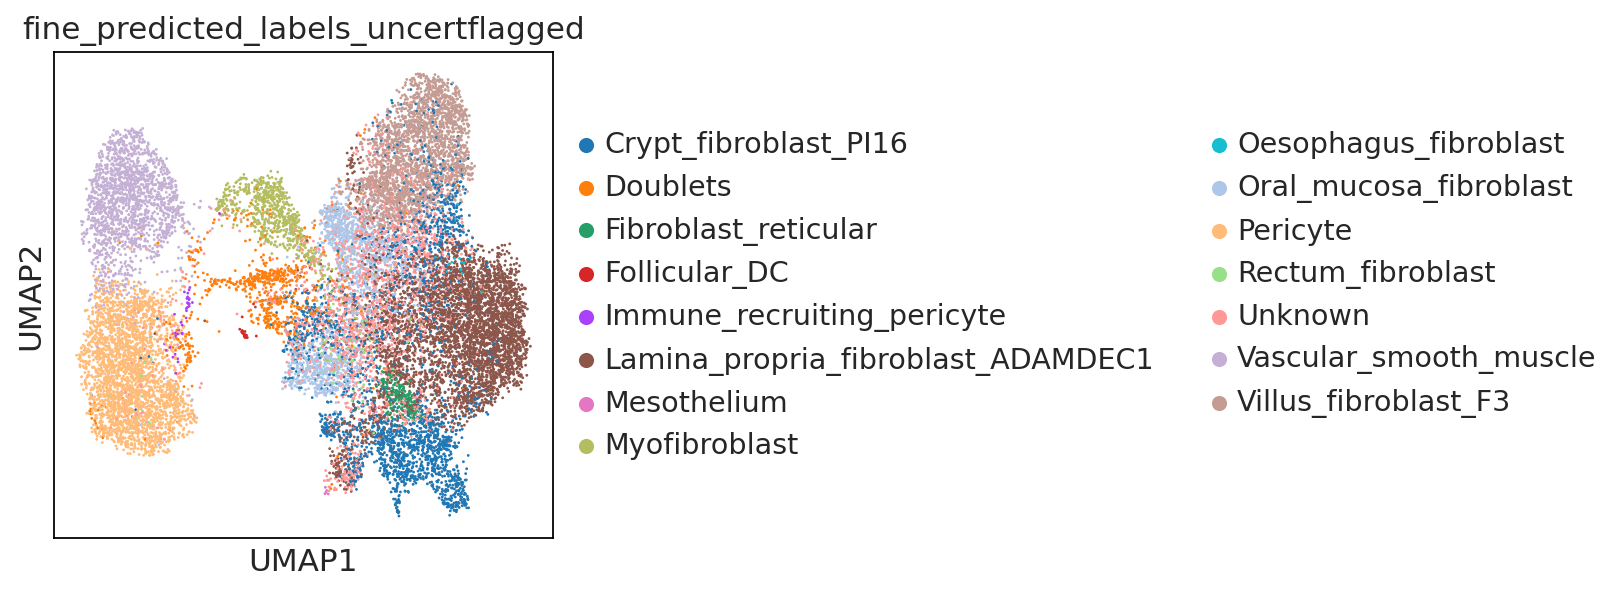

In [30]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

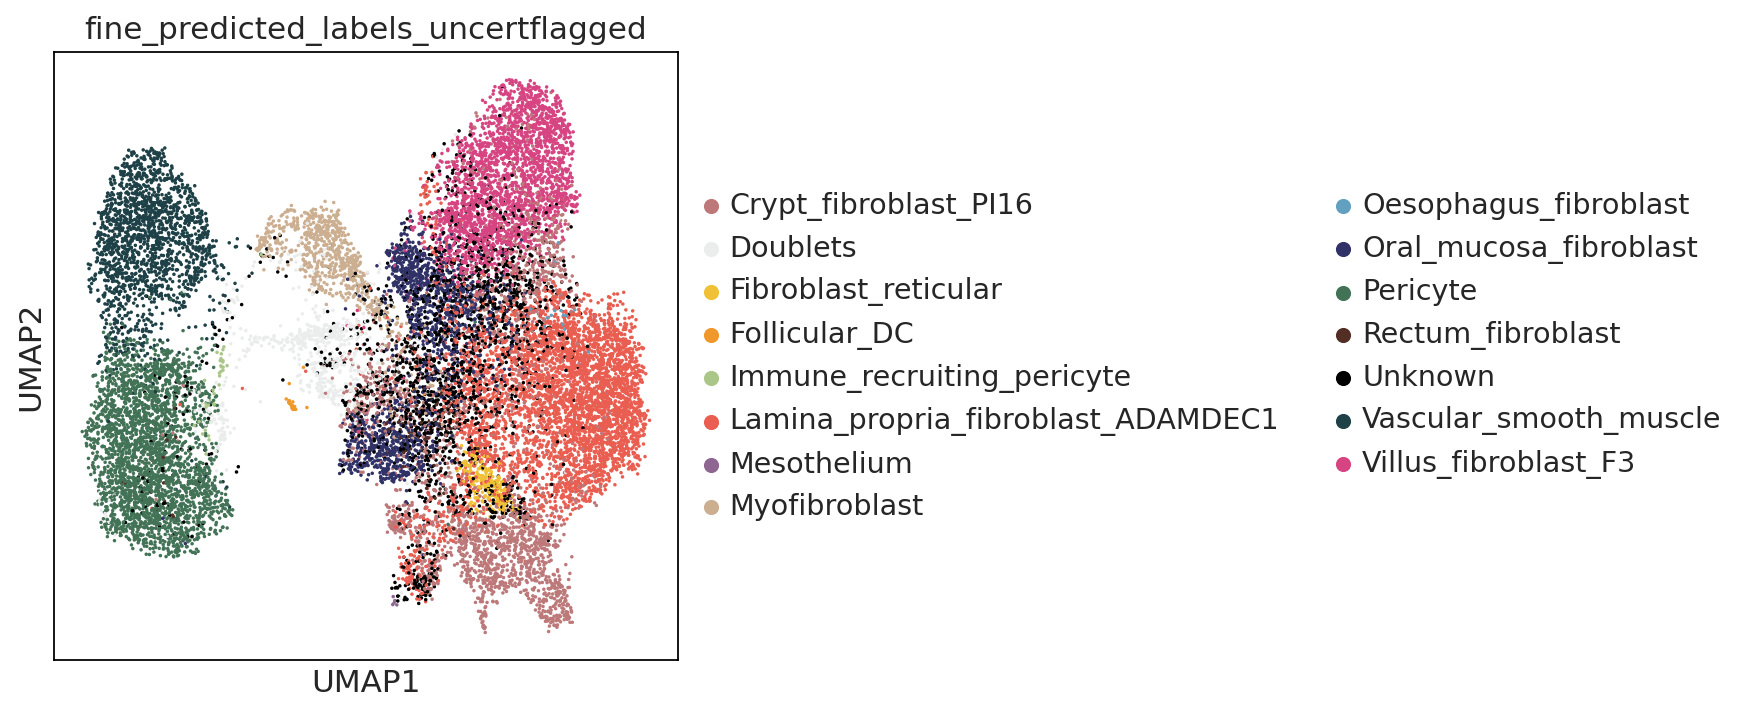

In [31]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#bd7879',#'Crypt_fibroblast_PI16', 
                                                          '#ebeded',#doublets
           '#f0c134',#'Stromal_fibroblast_reticular',
                                                                        '#f0982c',#'Follicular_DC', 
                                                          
           '#AAC789',#'Immune_recruiting_pericyte',
           '#e95e50',#'Lamina_propria_fibroblast_ADAMDEC1', 
           '#8F6592',#'Mesothelium', 
           '#CCAE91',#'Myofibroblast',
           '#63A0C0',#'Oesophagus_fibroblast', 
           '#303267',#'Oral_mucosa_fibroblast', 
           '#437356',#'Pericyte',
           '#522e25',#'Rectum_fibroblast',
           '#000000',#unknown
           '#1E4147',#'Vascular_smooth_muscle',
           '#d64582'#'Villus_fibroblast_F3'

                                                                       ],size=10,save='Mes_scanviannot_uncert.pdf')

In [32]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/Mes_disease_annot.csv',index_col=0)

In [33]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

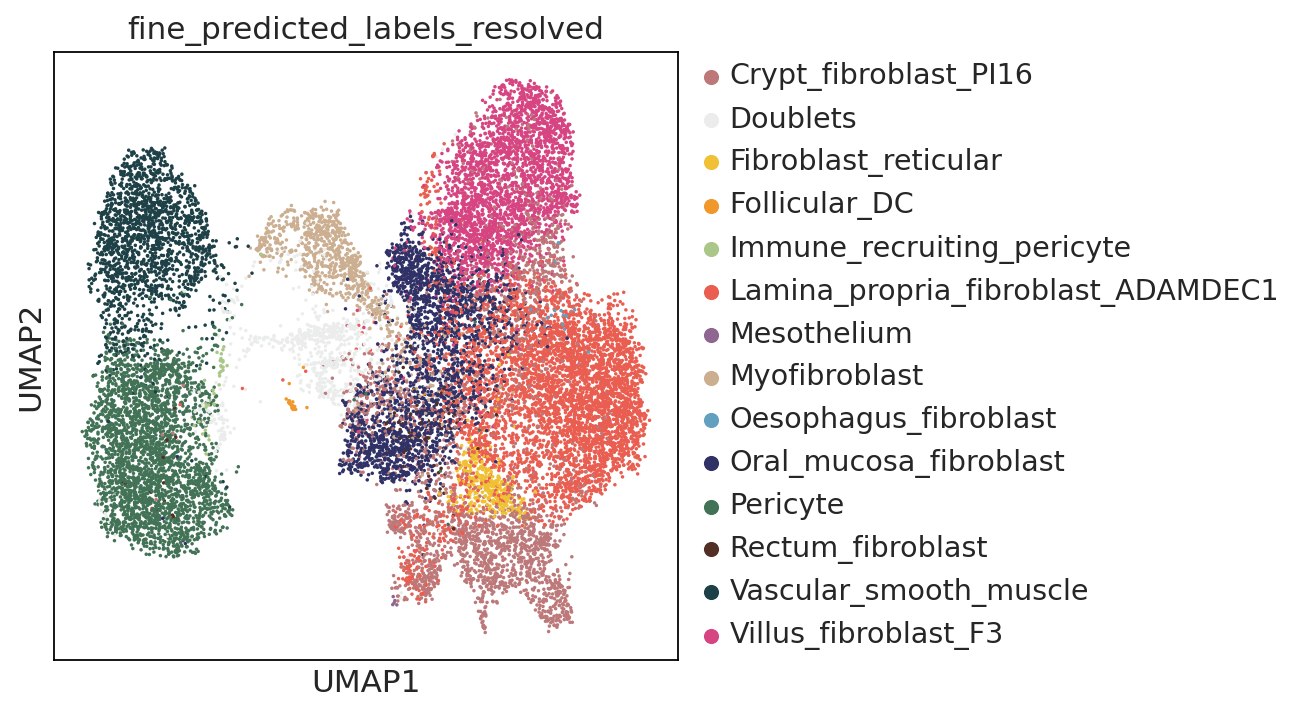

In [34]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#bd7879',#'Crypt_fibroblast_PI16', 
                                                          '#ebeded',#doublets
           '#f0c134',#'Stromal_fibroblast_reticular',
                                                                        '#f0982c',#'Follicular_DC', 
                                                          
           '#AAC789',#'Immune_recruiting_pericyte',
           '#e95e50',#'Lamina_propria_fibroblast_ADAMDEC1', 
           '#8F6592',#'Mesothelium', 
           '#CCAE91',#'Myofibroblast',
           '#63A0C0',#'Oesophagus_fibroblast', 
           '#303267',#'Oral_mucosa_fibroblast', 
           '#437356',#'Pericyte',
           '#522e25',#'Rectum_fibroblast',
           #'#000000',#unknown
           '#1E4147',#'Vascular_smooth_muscle',
           '#d64582'#'Villus_fibroblast_F3'

    
                                              ],size=10,save='Mes_scanviannot_resvoled.pdf')

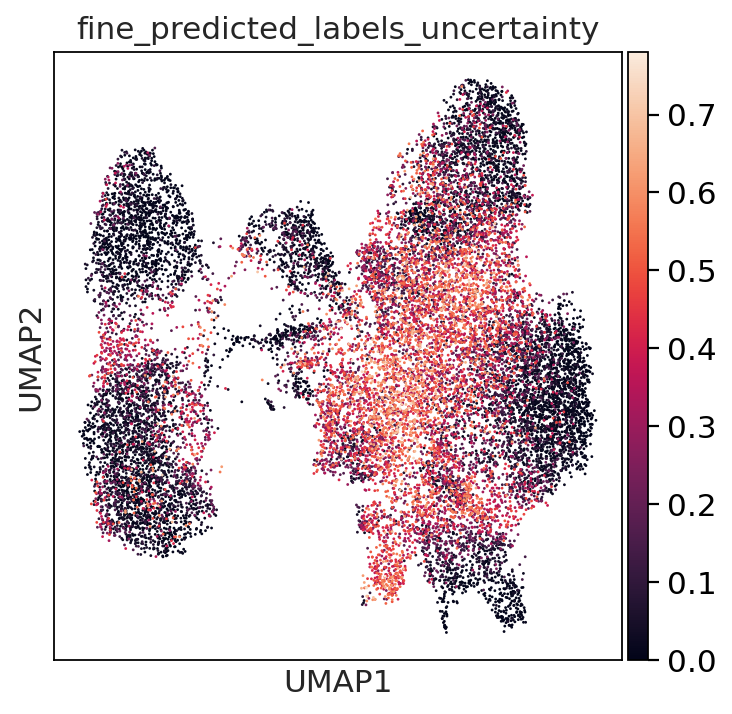

In [35]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty',save='Mes_scanviannot_uncertainty.pdf')

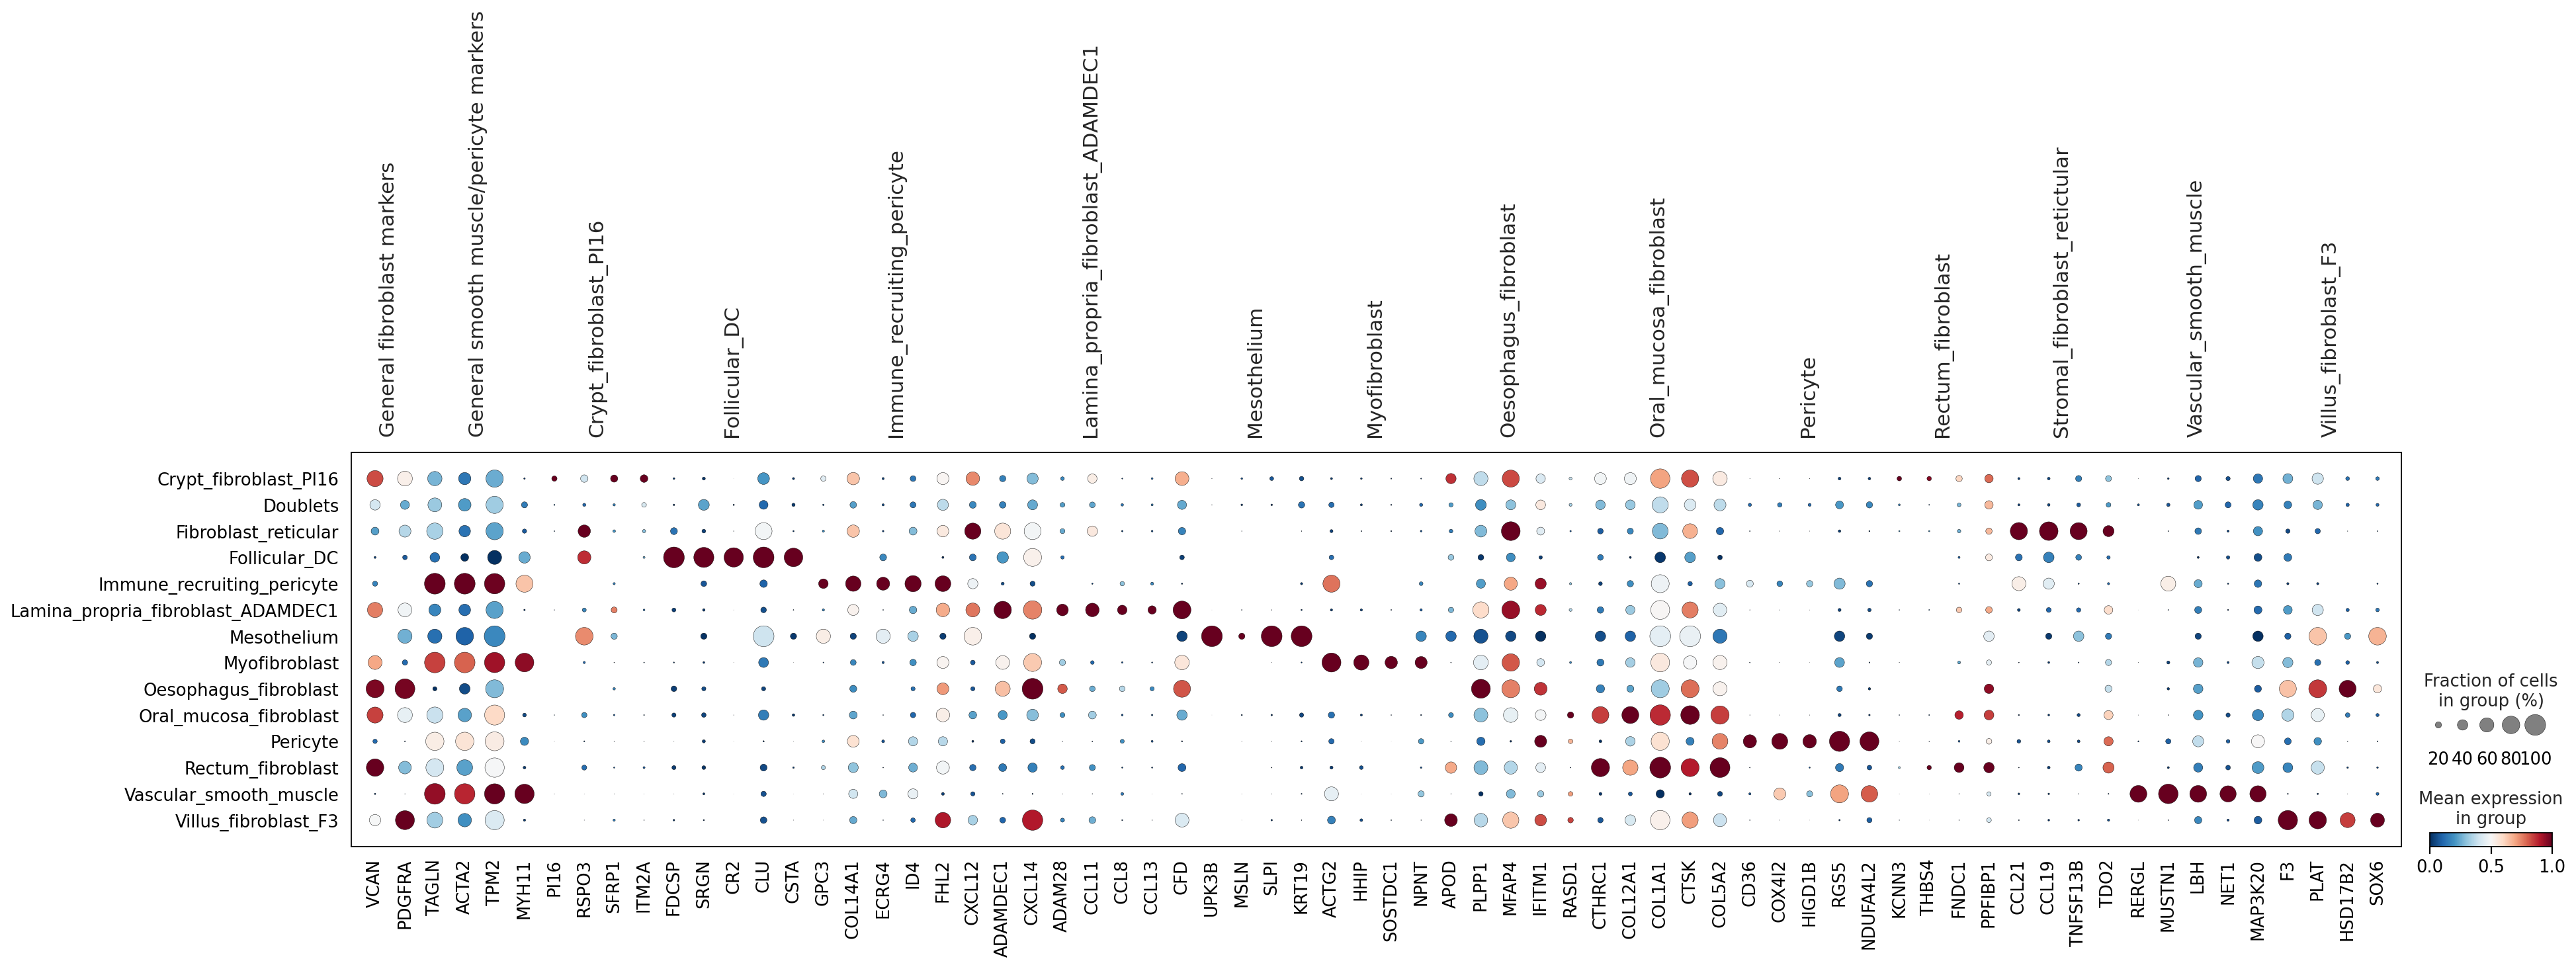

In [36]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels_resolved',color_map='RdBu_r', standard_scale='var',save='Mes_scanviannot_resvoledmarkers.pdf')

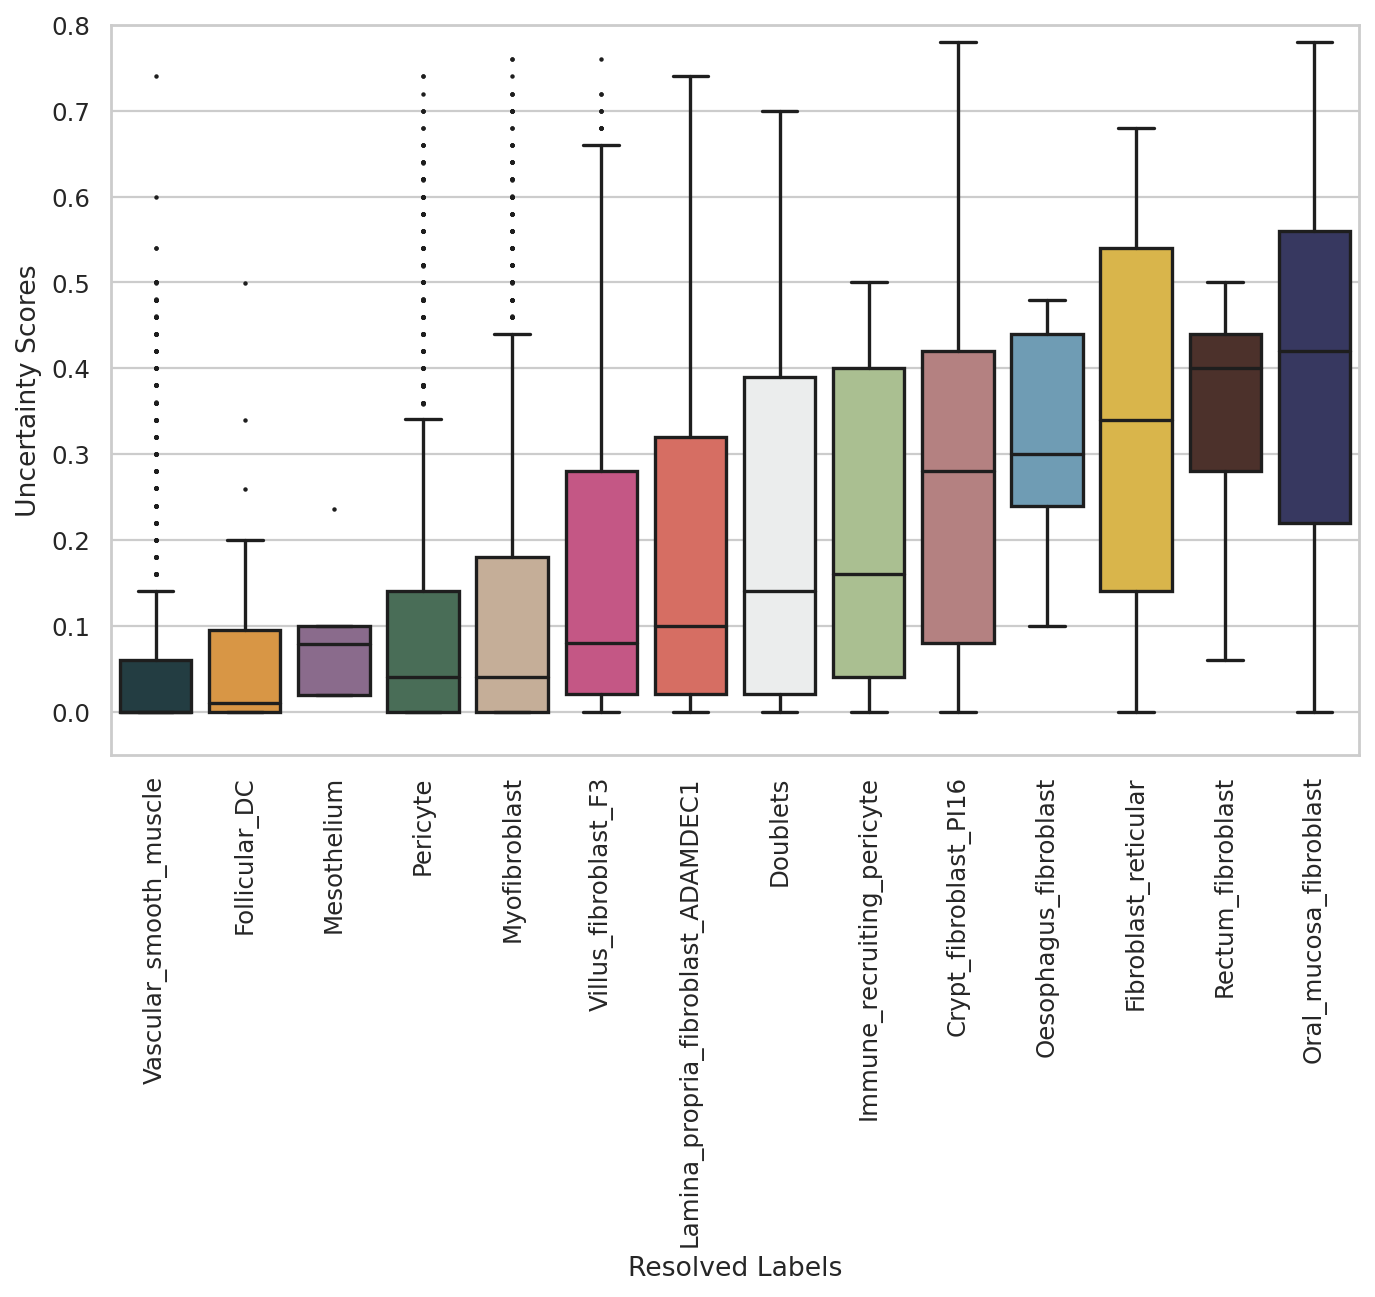

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the style

# Assuming adata is your AnnData object

# Combine the two variables into a DataFrame for easier plotting
data_to_plot = adata.obs[['fine_predicted_labels_uncertainty', 'fine_predicted_labels_resolved']]

# Use seaborn for better styling (optional)
sns.set(style="whitegrid")
colors = {'Crypt_fibroblast_PI16':'#bd7879', 'Doublets':'#ebeded',
           'Fibroblast_reticular':'#f0c134','Follicular_DC':'#f0982c',     
           'Immune_recruiting_pericyte':'#AAC789',
           'Lamina_propria_fibroblast_ADAMDEC1':'#e95e50', 
           'Mesothelium':'#8F6592', 
           'Myofibroblast':'#CCAE91',
           'Oesophagus_fibroblast':'#63A0C0',
           'Oral_mucosa_fibroblast':'#303267',
           'Pericyte':'#437356',
           'Rectum_fibroblast':'#522e25',
           'Vascular_smooth_muscle':'#1E4147',
           'Villus_fibroblast_F3':'#d64582'}

mean_uncertainty = data_to_plot.groupby('fine_predicted_labels_resolved')['fine_predicted_labels_uncertainty'].mean()

# Sort the categories based on mean uncertainty
sorted_categories = mean_uncertainty.sort_values().index

# Create a box and whisker plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.boxplot(x='fine_predicted_labels_resolved', y='fine_predicted_labels_uncertainty', 
            data=data_to_plot,palette=colors,order=sorted_categories,flierprops=dict(marker='o', markerfacecolor='gray', markersize=1))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Resolved Labels')
plt.ylabel('Uncertainty Scores')
ax.set_ylim(-0.05, 0.8)

# Save the plot as a PDF file
plt.savefig('Mes_boxplot_uncertainty_scores.pdf', format='pdf')

# Show the plot
plt.show()

In [38]:
omf = adata[adata.obs.fine_predicted_labels_resolved.isin(['Oral_mucosa_fibroblast'])].copy()

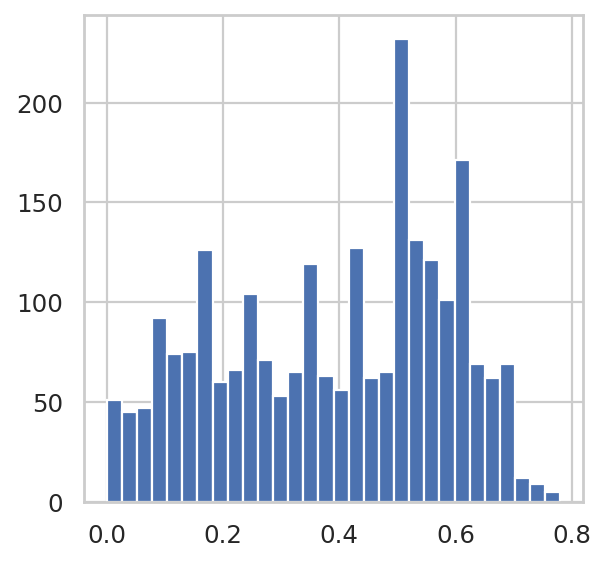

In [39]:
#plot uncertainty distribution
plt.hist(omf.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.savefig('Oral_mucosa_fibro_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [40]:
#related to revisions point 2.10 "Have you done differential gene expression analysis of the unknonw cells versus the annotated cells in their cluster?"

In [41]:
adata

AnnData object with n_obs × n_vars = 18903 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_spl

In [42]:
adata.obs['unknown_clusterlabel'] = adata.obs['fine_predicted_labels_uncertflagged'].astype(str) + '_' + adata.obs['fine_predicted_labels_resolved'].astype(str)

In [43]:
adata.obs['unknown_clusterlabel'].value_counts()

Lamina_propria_fibroblast_ADAMDEC1_Lamina_propria_fibroblast_ADAMDEC1    4255
Pericyte_Pericyte                                                        2741
Villus_fibroblast_F3_Villus_fibroblast_F3                                2448
Crypt_fibroblast_PI16_Crypt_fibroblast_PI16                              2391
Vascular_smooth_muscle_Vascular_smooth_muscle                            1728
Oral_mucosa_fibroblast_Oral_mucosa_fibroblast                            1463
Unknown_Oral_mucosa_fibroblast                                            940
Myofibroblast_Myofibroblast                                               729
Doublets_Doublets                                                         692
Unknown_Lamina_propria_fibroblast_ADAMDEC1                                311
Fibroblast_reticular_Fibroblast_reticular                                 249
Unknown_Villus_fibroblast_F3                                              234
Unknown_Crypt_fibroblast_PI16                                   

In [44]:
adata.X.max()

8.652122

         Falling back to preprocessing with `sc.pp.pca` and default params.


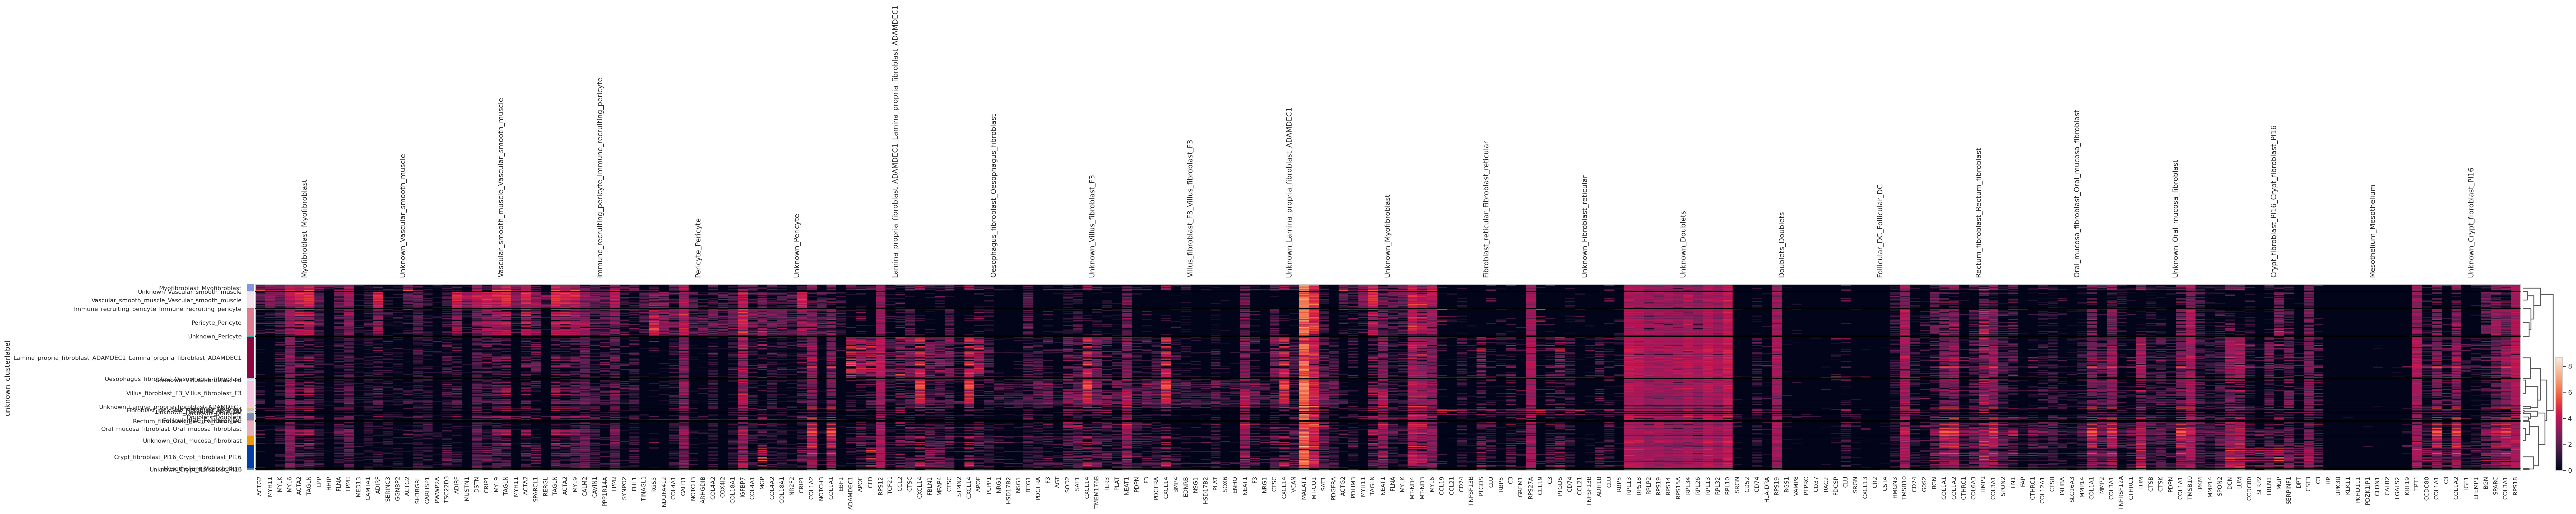

In [47]:
sc.tl.rank_genes_groups(adata, 'unknown_clusterlabel', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True)

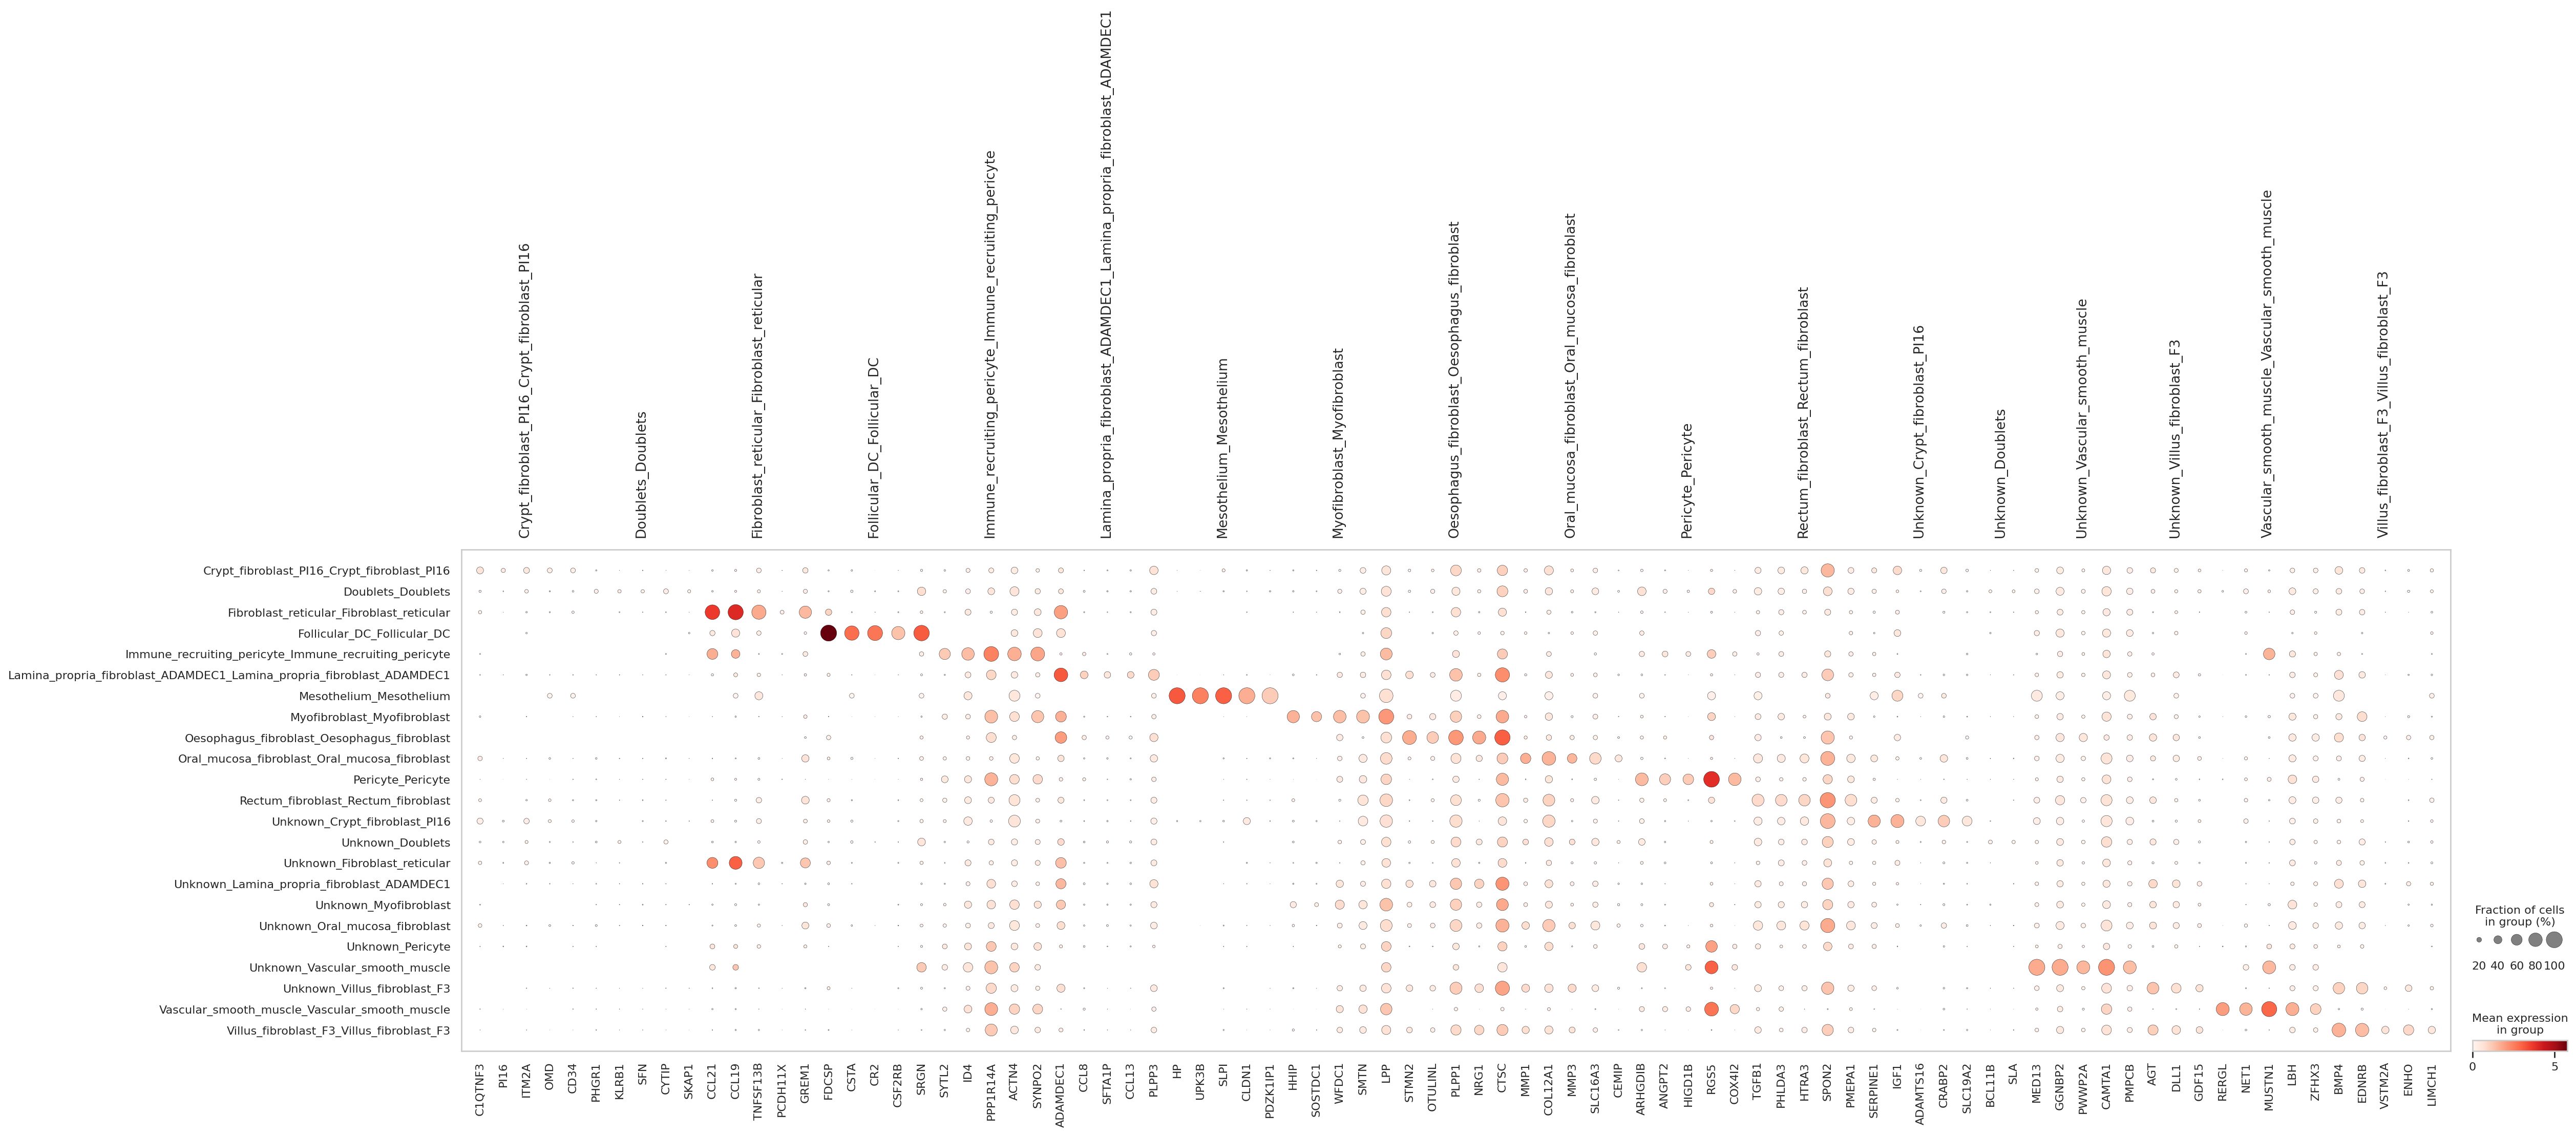

In [48]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata.raw = adata.copy()
mkst = calc_marker_stats(adata, groupby="unknown_clusterlabel")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata, groupby='unknown_clusterlabel', mks=mks)

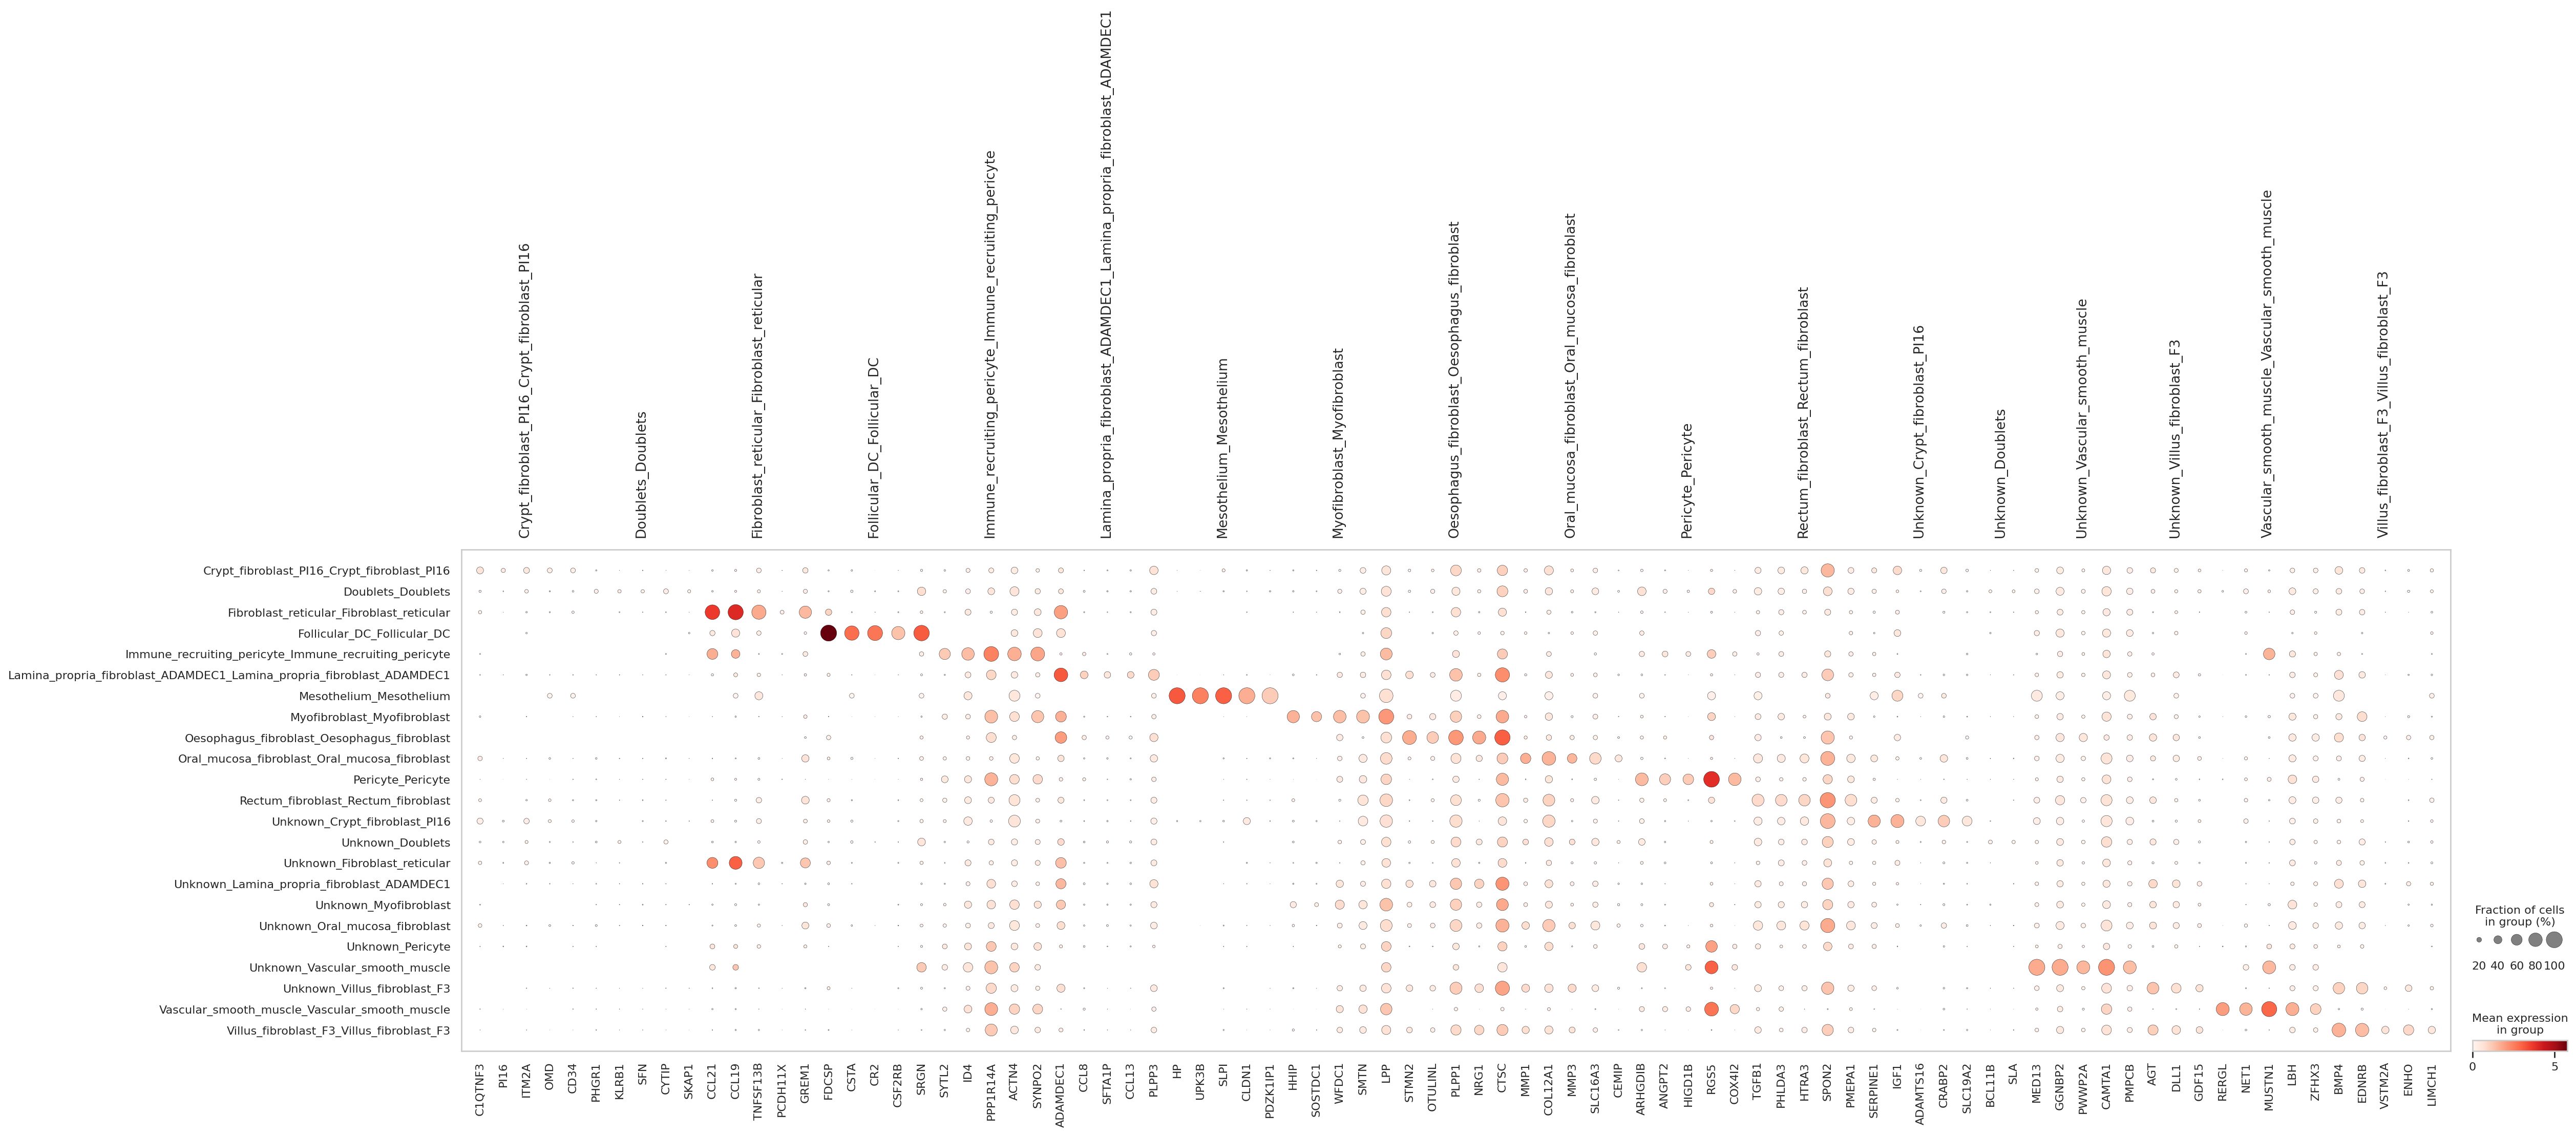

In [49]:
plot_markers(adata, groupby='unknown_clusterlabel', mks=mks,save='Mes_unknown_specificDGE.pdf')